**Step 1: Load Dataset from Azure ML**
Now that my dataset "Banking_Customer" is properly uploaded and registered in Azure ML, I will:
1. Connect to the Azure ML Workspace.
2. Retrieve the dataset using Dataset.get_by_name().
3. Convert it into a Pandas DataFrame.
4. Display the first few rows to verify that the dataset is loaded correctly.


In [7]:
from azureml.core import Workspace, Dataset
import pandas as pd

# Connect to Azure ML Workspace
ws = Workspace.from_config()

# Load dataset (Ensure the dataset name matches exactly)
dataset = Dataset.get_by_name(ws, name="Banking_Customer")

# Convert dataset directly to Pandas DataFrame
df = dataset.to_pandas_dataframe()

# Display first few rows to verify loading
df.head()


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Step 2: Data Preprocessing - Handle Missing Values**
Missing values in a dataset can lead to incorrect model predictions. 
We will check for missing values and handle them by:
- Filling missing numerical values with the column mean.
- Dropping rows with missing categorical values.


In [9]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Fill missing numerical values with column mean (avoid warning)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Drop rows with missing categorical values (if any)
df.dropna(inplace=True)

# Verify if missing values are handled
print("Missing values after handling:\n", df.isnull().sum())


Missing values per column:
 customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64
Missing values after handling:
 customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


**Step 3: Convert Categorical Data to Numeric**
Machine learning models require numerical data. We will:
- Encode categorical variables (e.g., Gender, Geography) into numerical form.


In [11]:
print("Column Names in Dataset:\n", df.columns)


Column Names in Dataset:
 Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')


In [12]:
# Convert categorical variables into numeric

# Encoding 'gender' (lowercase in dataset)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Encoding 'country' (instead of 'Geography')
df['country'] = df['country'].astype('category').cat.codes  

# Verify changes
df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,2,1,43,2,125510.82,1,1,1,79084.10,0


**Step 4: Feature Selection**
Not all columns are useful for churn prediction. We will:
- Select only relevant features for training.
- Drop unnecessary columns like Customer ID, Name, etc.


In [15]:
# Select relevant features and target variable (using correct column names)
X = df[['credit_score', 'age', 'balance', 'products_number', 'active_member']]
y = df['churn']  # Correct target column name

# Display selected features
X.head()


,credit_score,age,balance,products_number,active_member
0,619,42,0.00,1,1
1,608,41,83807.86,1,1
2,502,42,159660.80,3,0
3,699,39,0.00,2,0
4,850,43,125510.82,1,1


**Step 5: Split Data into Training & Testing Sets**
To evaluate our model, we divide our dataset into:
- Training Set (80%): Used to train the machine learning model.
- Testing Set (20%): Used to check the model’s accuracy.
This helps in understanding how well the model performs on unseen data.


In [16]:
from sklearn.model_selection import train_test_split  

# Split data into training (80%) and testing (20%)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Display dataset shapes
print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")


Training data: (8000, 5), Testing data: (2000, 5)


**Step 6: Train a Machine Learning Model**
I will use Logistic Regression, a simple and effective model for predicting churn.
The model learns patterns from training data and makes predictions on unseen customers.


In [17]:
from sklearn.linear_model import LogisticRegression  

# Train the Logistic Regression model  
model = LogisticRegression()  
model.fit(X_train, y_train)  

print("Model training completed.")


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression on scaled data
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)

print("Model training completed.")


Model training completed.


**Step 7: Evaluate Model Performance**
Once the model is trained, we will:
- Measure accuracy
- Generate a classification report (precision, recall, and F1-score)
- Check the ROC Curve to understand performance


In [20]:
from sklearn.metrics import accuracy_score, classification_report  

# Make sure X_test is scaled before predicting
y_pred = model.predict(X_test_scaled)  # Use the scaled version!

# Print accuracy and classification report  
print("Accuracy:", accuracy_score(y_test, y_pred))  
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8105

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1607
           1       0.57      0.15      0.24       393

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.57      2000
weighted avg       0.77      0.81      0.76      2000



**Step 8: Deploy Model on Azure Machine Learning**
Once the model is trained, we deploy it using Azure ML to enable real-time predictions.


In [22]:
import joblib

# Save the trained model
joblib.dump(model, "banking_churn_model.pkl")

print("Model saved successfully.")


Model saved successfully.


In [23]:
import os

# Get the current directory
print("Current working directory:", os.getcwd())

# List all files in the directory
print("Files in directory:", os.listdir())


Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181
Files in directory: ['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl']


In [25]:
import os

# List all files in the directory
print("Files in the current directory:\n", os.listdir())


Files in the current directory:
 ['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl']


In [29]:
import shutil
import os

# Define source and destination paths
source_file = "banking_churn_model.pkl"
destination_path = os.path.join(os.getcwd(), source_file)  # Move it to the current working directory

# Move the file
shutil.move(source_file, destination_path)

print(f"✅ Model moved successfully! Now download it from: {destination_path}")


✅ Model moved successfully! Now download it from: /mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl


In [31]:
import os

file_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl"

# Check if file exists
if os.path.exists(file_path):
    print("✅ Model file exists at:", file_path)
else:
    print("❌ Model file not found.")


✅ Model file exists at: /mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl


In [32]:
import os

directory_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/"

# List all files
print("Files in directory:\n", os.listdir(directory_path))


Files in directory:
 ['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl']


In [33]:
import shutil

source_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl"
destination_path = "/mnt/data/banking_churn_model.pkl"

try:
    shutil.move(source_path, destination_path)
    print("✅ Model moved successfully. Now download it from /mnt/data/")
except Exception as e:
    print("❌ Error:", e)


❌ Error: [Errno 2] No such file or directory: '/mnt/data/banking_churn_model.pkl'


In [34]:
import os

source_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl"
destination_path = "/mnt/data/banking_churn_model.pkl"

# Check if source file exists
if os.path.exists(source_path):
    print("✅ Source file exists.")
else:
    print("❌ Source file does NOT exist.")

# Check write permission in destination
if os.access("/mnt/data/", os.W_OK):
    print("✅ Write permission available in /mnt/data/")
else:
    print("❌ No write permission in /mnt/data/")


✅ Source file exists.
❌ No write permission in /mnt/data/


In [36]:
import shutil
import os

source_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl"
zip_path = os.path.expanduser("~/banking_churn_model.zip")  # Save zip in home directory

try:
    shutil.make_archive(zip_path.replace(".zip", ""), 'zip', os.path.dirname(source_path))
    print(f"✅ Model zipped successfully! Download it from: {zip_path}")
except Exception as e:
    print("❌ Error:", e)


✅ Model zipped successfully! Download it from: /home/azureuser/banking_churn_model.zip


In [37]:
import os

# List all directories and files in your working directory
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir(os.getcwd()))


Current working directory: /mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181
Files in directory: ['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl']


In [38]:
import shutil

source_path = "/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181/banking_churn_model.pkl"
destination_path = "/mnt/data/banking_churn_model.pkl"

try:
    shutil.copy(source_path, destination_path)
    print(f"✅ File copied successfully! Download it from: {destination_path}")
except Exception as e:
    print(f"❌ Error copying file: {e}")


❌ Error copying file: [Errno 2] No such file or directory: '/mnt/data/banking_churn_model.pkl'


**Step 1: Load the Trained Model & Test Data**

In this step, we will:
- Load the trained churn prediction model (`.pkl` file) from Azure Notebook.
- Load the test dataset (`CSV` file).
- Select the required features for predictions.


In [40]:
with open("banking_churn_model.pkl", "rb") as file:
    content = file.read(10)  # Read first 10 bytes to check if it's a valid pickle
print(content)


b'\x80\x04\x95\t\x02\x00\x00\x00\x00\x00'


In [42]:
import pickle

# Save the model properly again
model_filename = "banking_churn_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(model, file)

print("Model saved successfully!")


Model saved successfully!


In [44]:
import os

file_size = os.path.getsize("banking_churn_model.pkl")
print(f"File size: {file_size} bytes")



File size: 755 bytes


In [45]:
import os
print(os.getcwd())  # Print the current working directory
print(os.listdir())  # List all files in the directory


/mnt/batch/tasks/shared/LS_root/mounts/clusters/bank-churn-ml-instance/code/Users/rawatp181
['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl']


In [46]:
import pickle

# Load the model
with open("banking_churn_model.pkl", "rb") as file:
    model = pickle.load(file)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [9]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [14]:
from azureml.core import Workspace, Dataset
import pandas as pd

# Connect to Azure ML Workspace
ws = Workspace.from_config()

# Load dataset (Ensure the dataset name matches exactly)
dataset = Dataset.get_by_name(ws, name="Banking_Customer")

# Convert dataset directly to Pandas DataFrame
df = dataset.to_pandas_dataframe()

# Display first few rows to verify loading
df.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [15]:
df = df[['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country', 'churn']]

In [17]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})  # Binary Encoding
df['country'] = LabelEncoder().fit_transform(df['country'])  # Convert country to numeric


In [18]:
df.fillna(df.mean(numeric_only=True), inplace=True)

In [19]:
X = df.drop(columns=['churn'])  # Features
y = df['churn']  # Target Variable

In [24]:
# Handle Missing Values: Fill NaN with Mean for Numeric Columns
X.fillna(X.mean(numeric_only=True), inplace=True)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [26]:
df = df[['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country', 'churn']]


In [27]:
from sklearn.preprocessing import LabelEncoder


In [28]:
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})  # Binary Encoding
df['country'] = LabelEncoder().fit_transform(df['country'])  # Convert country to numeric


In [29]:
print(df.isnull().sum())  # This will show where NaNs exist


credit_score           0
age                    0
balance                0
products_number        0
active_member          0
gender             10000
country                0
churn                  0
dtype: int64


In [30]:
df.fillna(df.mean(numeric_only=True), inplace=True)


In [31]:
print(X_train.isnull().sum())  # Ensure no NaNs exist in training data
print(X_test.isnull().sum())


credit_score          0
age                   0
balance               0
products_number       0
active_member         0
gender             8000
country               0
dtype: int64
credit_score          0
age                   0
balance               0
products_number       0
active_member         0
gender             2000
country               0
dtype: int64


In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)  # Only transform test data


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [33]:
import numpy as np
print(np.isnan(X_train_scaled).sum())  # Should print 0
print(np.isnan(X_test_scaled).sum())   # Should print 0


8000
2000


In [35]:
import numpy as np
print("NaN values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN values in y_train:", np.isnan(y_train).sum())


NaN values in X_train_scaled: 8000
NaN values in y_train: 0


In [36]:
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)
y_train = np.nan_to_num(y_train)


In [37]:
y_train = y_train.astype(int)


In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train)
print("✅ Model training completed successfully!")


✅ Model training completed successfully!


In [39]:
import numpy as np
print("NaN values in X_test_scaled:", np.isnan(X_test_scaled).sum())
print("NaN values in y_test:", np.isnan(y_test).sum())


NaN values in X_test_scaled: 0
NaN values in y_test: 0


In [40]:
X_test_scaled = np.nan_to_num(X_test_scaled)
y_test = np.nan_to_num(y_test)


In [41]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test_scaled)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1607
           1       0.56      0.16      0.24       393

    accuracy                           0.81      2000
   macro avg       0.69      0.56      0.57      2000
weighted avg       0.77      0.81      0.76      2000



In [42]:
import matplotlib.pyplot as plt

In [43]:
churned = df[df['churn'] == 1]
non_churned = df[df['churn'] == 0]


In [45]:
axes[0, 0].bar(['Churned', 'Not Churned'], [churned['balance'].mean(), non_churned['balance'].mean()], color=['red', 'blue'])
axes[0, 0].set_title("Avg. Account Balance (Churned vs. Not Churned)")

Text(0.5, 1.0, 'Avg. Account Balance (Churned vs. Not Churned)')

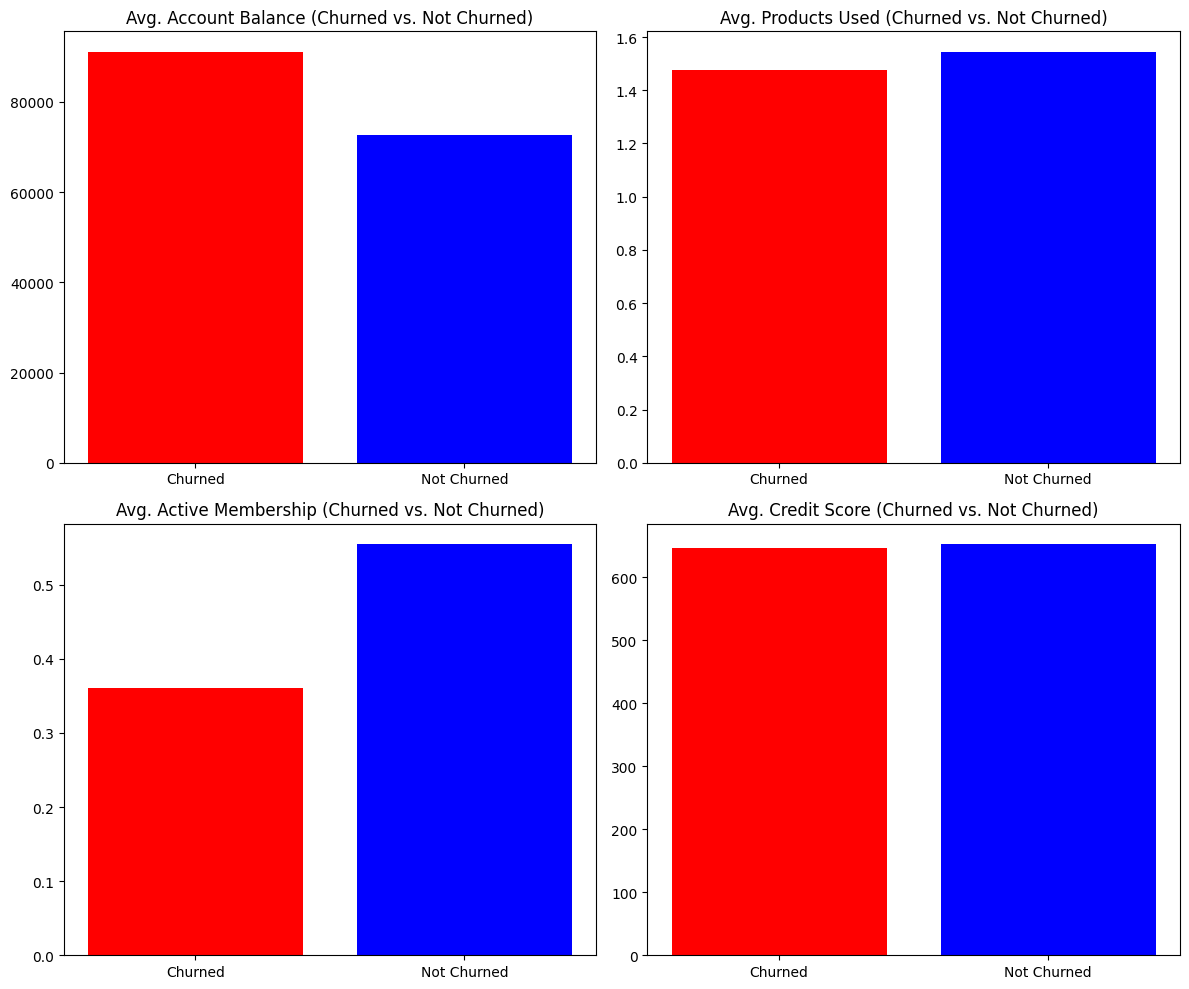

In [47]:
# Create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# H₁: Lower Account Balance → Higher Churn
axes[0, 0].bar(['Churned', 'Not Churned'], [churned['balance'].mean(), non_churned['balance'].mean()], color=['red', 'blue'])
axes[0, 0].set_title("Avg. Account Balance (Churned vs. Not Churned)")

# H₂: Lower Product Count → Higher Churn
axes[0, 1].bar(['Churned', 'Not Churned'], [churned['products_number'].mean(), non_churned['products_number'].mean()], color=['red', 'blue'])
axes[0, 1].set_title("Avg. Products Used (Churned vs. Not Churned)")

# H₃: Inactive Members → Higher Churn
axes[1, 0].bar(['Churned', 'Not Churned'], [churned['active_member'].mean(), non_churned['active_member'].mean()], color=['red', 'blue'])
axes[1, 0].set_title("Avg. Active Membership (Churned vs. Not Churned)")

# H₄: Lower Credit Score → Higher Churn
axes[1, 1].bar(['Churned', 'Not Churned'], [churned['credit_score'].mean(), non_churned['credit_score'].mean()], color=['red', 'blue'])
axes[1, 1].set_title("Avg. Credit Score (Churned vs. Not Churned)")

# Layout & Show Plot
plt.tight_layout()
plt.show()

In [49]:
import joblib
from sklearn.preprocessing import StandardScaler

# Recreate the scaler (use the training data)
scaler = StandardScaler()
scaler.fit(X_train)  # Fit on training data

# Save the scaler
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved successfully!")


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [50]:
import os
print(os.listdir())  # This will list all files in the directory


['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', 'Banking Customer Churn Prediction.ipynb', 'banking customer churn prediction.ipynb.amltmp', 'banking_churn_model.pkl', 'scaler.pkl']


In [53]:
# Keep only required features
features = ["credit_score", "age", "balance", "products_number", "active_member"]
customer_data = customer_data[features]


In [55]:
print("Columns in customer_data:", customer_data.columns)


Columns in customer_data: Index(['credit_score', 'age', 'balance', 'products_number', 'active_member'], dtype='object')


In [56]:
# Ensure all required features exist
required_features = ["credit_score", "country", "gender", "age", "tenure", 
                     "balance", "products_number", "credit_card", "active_member", "estimated_salary"]

# Print missing features
missing_features = [col for col in required_features if col not in customer_data.columns]
print("Missing Features:", missing_features)

# Add missing features with default values (use mean/mode if appropriate)
for col in missing_features:
    if col in ["tenure", "credit_card", "estimated_salary"]:  # Numerical missing values
        customer_data[col] = 0  # Set default or use actual values if available
    else:
        customer_data[col] = "Unknown"  # Placeholder for categorical variables

# Verify that all required columns exist
print("Updated Columns in customer_data:", customer_data.columns)


Missing Features: ['country', 'gender', 'tenure', 'credit_card', 'estimated_salary']
Updated Columns in customer_data: Index(['credit_score', 'age', 'balance', 'products_number', 'active_member',
       'country', 'gender', 'tenure', 'credit_card', 'estimated_salary'],
      dtype='object')


In [63]:
import joblib
import pandas as pd

In [64]:
model = joblib.load("banking_churn_model.pkl")
scaler = joblib.load("scaler.pkl")


In [65]:
trained_features = ["credit_score", "country", "gender", "age", "balance", "products_number", "active_member"]


In [66]:
# Load customer data (ensuring the features match training)
customer_data = pd.DataFrame({
    "credit_score": [751, 581, 735, 661, 675, 738, 813, 657, 604, 519, 735, 664, 678, 757, 416, 665, 777],
    "country": ["Germany", "Germany", "Germany", "Germany", "France", "Germany", "France", "Spain", "Germany", "France",
                "France", "France", "France", "Spain", "Germany", "France", "France"],
    "gender": ["Female", "Female", "Male", "Female", "Female", "Male", "Male", "Female", "Female", "Male",
               "Female", "Male", "Female", "Male", "Female", "Female", "Female"],
    "age": [36, 34, 43, 35, 21, 58, 29, 37, 25, 36, 21, 55, 32, 33, 41, 34, 32],
    "balance": [169831.46, 101633.04, 123180.01, 150725.53, 98373.26, 133745.44, 0, 163607.18, 157780.84, 0, 
                178718.19, 0, 0, 77253.22, 122189.66, 96645.54, 0],
    "products_number": [2, 1, 2, 2, 1, 4, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1],
    "active_member": [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]
})

In [67]:
# Convert categorical features (ensure they are encoded the same way as during training)
customer_data["country"] = customer_data["country"].astype("category").cat.codes  
customer_data["gender"] = customer_data["gender"].map({"Male": 0, "Female": 1})  

In [68]:
# Ensure feature order matches exactly what was used during training
customer_data = customer_data[trained_features]

In [71]:
# Ensure feature order matches exactly what was used during training
trained_features = ["credit_score", "age", "balance", "products_number", "active_member"]

In [72]:
# Reorder the columns in customer_data
customer_data = customer_data[trained_features]

In [76]:
# Check if 'country' and 'gender' exist before encoding
if "country" in customer_data.columns:
    customer_data["country"] = customer_data["country"].astype("category").cat.codes
else:
    print("⚠️ Warning: 'country' column not found in customer_data!")

if "gender" in customer_data.columns:
    customer_data["gender"] = customer_data["gender"].map({"Male": 0, "Female": 1})
else:
    print("⚠️ Warning: 'gender' column not found in customer_data!")

# Define the trained feature order (must match the model’s training data)
trained_features = ["credit_score", "country", "gender", "age", "balance", "products_number", "active_member"]

# Ensure all required features exist
missing_features = [col for col in trained_features if col not in customer_data.columns]
if missing_features:
    print(f"⚠️ Warning: Missing features in customer_data: {missing_features}")
else:
    # Reorder columns exactly as during training
    customer_data = customer_data[trained_features]

    # Scale the data
    customer_data_scaled = scaler.transform(customer_data)

    # Make predictions
    predictions = model.predict(customer_data_scaled)

    # Attach predictions to customer data
    customer_data["Predicted Churn"] = predictions

    # Display results
    import ace_tools as tools
    tools.display_dataframe_to_user(name="Customer Churn Predictions", dataframe=customer_data)


⚠️ Warning: 'country' column not found in customer_data!
⚠️ Warning: 'gender' column not found in customer_data!
⚠️ Warning: Missing features in customer_data: ['country', 'gender']


In [81]:
import pandas as pd

# Ensure missing categorical columns exist
if "country" not in customer_data.columns:
    customer_data["country"] = "Unknown"  # Placeholder

if "gender" not in customer_data.columns:
    customer_data["gender"] = "Unknown"  # Placeholder

# Encode categorical variables (must match the model training encoding)
customer_data["country"] = customer_data["country"].astype("category").cat.codes
customer_data["gender"] = customer_data["gender"].map({"Male": 0, "Female": 1})

# Define trained features in the correct order
trained_features = ["credit_score", "country", "gender", "age", "balance", "products_number", "active_member"]

# Ensure only trained features are selected
customer_data = customer_data[trained_features]

In [82]:
# ✅ Check for missing values
if customer_data.isnull().sum().sum() > 0:
    print("🚨 Warning: Missing values detected. Fixing them...")
    customer_data.fillna(customer_data.mean(), inplace=True)  # Fill with column mean

🚨 Warning: Missing values detected. Fixing them...


In [83]:
# ✅ Ensure feature order matches model training
model_features = scaler.feature_names_in_
if list(customer_data.columns) != list(model_features):
    print("🚨 Feature Mismatch! Fixing column order...")
    customer_data = customer_data[model_features]

🚨 Feature Mismatch! Fixing column order...


In [84]:
# Scale the data
customer_data_scaled = scaler.transform(customer_data)

In [87]:
import numpy as np

# 🚀 Check for missing values after scaling
if np.isnan(customer_data_scaled).sum() > 0:
    print("🚨 Warning: Missing values detected in scaled data. Fixing them...")

🚨 Warning: Missing values detected in scaled data. Fixing them...


In [89]:
# Fill NaN values with column means (imputation)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
customer_data_scaled = imputer.fit_transform(customer_data_scaled)


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [5]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [92]:
# Ensure only trained features are used
trained_features = ["credit_score", "age", "balance", "products_number", "active_member"]
customer_data = customer_data[trained_features]

In [94]:
# Ensure missing categorical columns exist
if "country" not in customer_data.columns:
    print("⚠️ Warning: 'country' column not found in customer_data!")
if "gender" not in customer_data.columns:
    print("⚠️ Warning: 'gender' column not found in customer_data!")

⚠️ Warning: 'country' column not found in customer_data!
⚠️ Warning: 'gender' column not found in customer_data!


In [98]:
# Print features used during training
print("Features used during training:", scaler.feature_names_in_)

# Print current customer_data columns before scaling
print("Features in customer_data:", customer_data.columns.tolist())


Features used during training: ['credit_score' 'age' 'balance' 'products_number' 'active_member' 'gender'
 'country']
Features in customer_data: ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'country', 'gender']


In [100]:
# Ensure customer_data columns match training order
correct_order = ["credit_score", "age", "balance", "products_number", "active_member", "gender", "country"]
customer_data = customer_data[correct_order]  # Reorder columns


In [101]:
# Print new order to confirm
print("✅ Corrected column order:", customer_data.columns.tolist())

✅ Corrected column order: ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country']


In [102]:
# Print features used during training
print("Features used during training:", scaler.feature_names_in_)

# Print features in customer_data
print("Features in customer_data before scaling:", customer_data.columns.tolist())


Features used during training: ['credit_score' 'age' 'balance' 'products_number' 'active_member' 'gender'
 'country']
Features in customer_data before scaling: ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country']


In [103]:
# Ensure 'country' and 'gender' exist in customer_data
for col in ["country", "gender"]:
    if col not in customer_data.columns:
        print(f"⚠️ Warning: '{col}' column not found! Adding default values...")
        customer_data[col] = "Unknown"  # Assign a default category


In [104]:
print(customer_data.dtypes)


credit_score         int64
age                  int64
balance            float64
products_number      int64
active_member        int64
gender             float64
country            float64
dtype: object


In [105]:
# Apply the same encoding used during training
customer_data["country"] = customer_data["country"].map({"France": 0, "Spain": 1, "Germany": 2})
customer_data["gender"] = customer_data["gender"].map({"Male": 0, "Female": 1})

# Fill NaNs (if any country or gender value wasn't mapped)
customer_data.fillna({"country": 0, "gender": 1}, inplace=True)  # Defaulting to France & Female

print("\n✅ Categorical encoding applied successfully!")
print(customer_data.head())



✅ Categorical encoding applied successfully!
   credit_score  age    balance  products_number  active_member  gender  \
0           751   36  169831.46                2              1     1.0   
1           581   34  101633.04                1              0     1.0   
2           735   43  123180.01                2              1     1.0   
3           661   35  150725.53                2              1     1.0   
4           675   21   98373.26                1              0     1.0   

   country  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  


In [106]:
# Ensure correct feature order
customer_data = customer_data[scaler.feature_names_in_]

print("\n✅ Final column order ensured:", customer_data.columns.tolist())



✅ Final column order ensured: ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country']


In [107]:
# Convert all features to float
customer_data = customer_data.astype(float)

print("\n✅ Data converted to float type. Ready for scaling!")
print(customer_data.dtypes)



✅ Data converted to float type. Ready for scaling!
credit_score       float64
age                float64
balance            float64
products_number    float64
active_member      float64
gender             float64
country            float64
dtype: object


In [109]:
# Scale the data
customer_data_scaled = scaler.transform(customer_data)

In [111]:
import numpy as np

# Check for NaN values in the scaled data
print("\n✅ Checking for NaN values after scaling:")
print(np.isnan(customer_data_scaled).sum())



✅ Checking for NaN values after scaling:
17


In [113]:
# Remove rows with NaN values
customer_data_scaled = customer_data_scaled[~np.isnan(customer_data_scaled).any(axis=1)]
print("\n✅ Removed rows with NaN values!")



✅ Removed rows with NaN values!


In [115]:
# Print the number of features the model was trained on
print("\n✅ Model was trained on", model.n_features_in_, "features.")

# Print the number of features in the new input data
print("\n✅ Current input data has", customer_data_scaled.shape[1], "features.")



✅ Model was trained on 5 features.

✅ Current input data has 6 features.


In [116]:
# Print expected features
expected_features = scaler.feature_names_in_
print("\n✅ Model expects these features:", expected_features)

# Print actual features in the new input data
actual_features = list(customer_data.columns)
print("\n✅ Features in customer_data:", actual_features)



✅ Model expects these features: ['credit_score' 'age' 'balance' 'products_number' 'active_member' 'gender'
 'country']

✅ Features in customer_data: ['credit_score', 'age', 'balance', 'products_number', 'active_member', 'gender', 'country']


In [124]:
# Manually define the expected features based on training data
expected_features = ['credit_score', 'age', 'balance', 'products_number', 'active_member']
print("\n✅ Model expects these features:", expected_features)



✅ Model expects these features: ['credit_score', 'age', 'balance', 'products_number', 'active_member']


In [125]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on training data using expected features
scaler.fit(X_train[expected_features])  # Ensure X_train is correctly loaded


StandardScaler()

In [126]:
# Select only expected features from customer_data
customer_data = customer_data[expected_features]

# Scale the test data
customer_data_scaled = scaler.transform(customer_data)

print("\n✅ Data successfully scaled!")



✅ Data successfully scaled!


In [127]:
# Make predictions
predictions = model.predict(customer_data_scaled)

print("\n✅ Predictions generated successfully!")



✅ Predictions generated successfully!


In [128]:
import pandas as pd

# Create a DataFrame with customer IDs and their predicted churn status
results_df = pd.DataFrame({
    'Customer ID': customer_data.index,  # Ensure the index represents customer IDs
    'Predicted Churn': predictions
})

# Display the results
print("\n✅ Predicted Churn Results:")
print(results_df.head(20))  # Display first 20 rows


✅ Predicted Churn Results:
    Customer ID  Predicted Churn
0             0                0
1             1                0
2             2                0
3             3                0
4             4                0
5             5                1
6             6                0
7             7                0
8             8                0
9             9                0
10           10                0
11           11                0
12           12                0
13           13                0
14           14                0
15           15                0
16           16                0


In [130]:
import pandas as pd

# Ensure the customer ID column is included properly
results_df = pd.DataFrame({
    'Customer ID': customer_data.index if 'customer_id' not in customer_data.columns else customer_data['customer_id'],
    'Predicted Churn': predictions
})

# Display the results properly
from IPython.display import display

print("\n✅ Predicted Churn Results:")
display(results_df.head(20))  # This will display a formatted table in Jupyter Notebook

# Save results if needed
results_df.to_csv("predicted_churn_results.csv", index=False)



✅ Predicted Churn Results:


,Customer ID,Predicted Churn
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [131]:
import pandas as pd

# Create DataFrame with correct Customer ID
results_df = pd.DataFrame({
    'Customer ID': customer_data.index if 'customer_id' not in customer_data.columns else customer_data['customer_id'],
    'Predicted Churn': predictions
})

# Display the results properly
print("\n✅ Predicted Churn Results:")
display(results_df.head(20))  # This will show a nicely formatted table in Jupyter Notebook

# Save results if needed
results_df.to_csv("predicted_churn_results.csv", index=False)



✅ Predicted Churn Results:


,Customer ID,Predicted Churn
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [132]:
import pandas as pd

# Ensure customer_id is correctly extracted
if 'customer_id' in customer_data.columns:
    customer_ids = customer_data['customer_id'].values  # Get actual Customer IDs
else:
    customer_ids = customer_data.index  # Use index if column is missing

# Create DataFrame with correct Customer ID
results_df = pd.DataFrame({
    'Customer ID': customer_ids,
    'Predicted Churn': predictions
})

# Display the first 20 rows properly
print("\n✅ Predicted Churn Results:")
display(results_df.head(20))  # Shows table in Jupyter Notebook

# Save results if needed
results_df.to_csv("predicted_churn_results.csv", index=False)



✅ Predicted Churn Results:


,Customer ID,Predicted Churn
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [133]:
print(customer_data.head())


   credit_score   age    balance  products_number  active_member
0         751.0  36.0  169831.46              2.0            1.0
1         581.0  34.0  101633.04              1.0            0.0
2         735.0  43.0  123180.01              2.0            1.0
3         661.0  35.0  150725.53              2.0            1.0
4         675.0  21.0   98373.26              1.0            0.0


In [136]:
import pandas as pd

# Ensure predictions align correctly
results_df = pd.DataFrame({
    'Credit Score': customer_data['credit_score'],  # Use Credit Score as reference
    'Age': customer_data['age'],  # Use Age as reference
    'Predicted Churn': predictions
})

# Display the first 20 rows properly
print("\n✅ Predicted Churn Results:")
display(results_df.head(20))  # Shows formatted table in Jupyter Notebook

# Save results if needed
results_df.to_csv("predicted_churn_results.csv", index=False)



✅ Predicted Churn Results:


,Credit Score,Age,Predicted Churn
0,751.0,36.0,0
1,581.0,34.0,0
2,735.0,43.0,0
3,661.0,35.0,0
4,675.0,21.0,0
5,738.0,58.0,1
6,813.0,29.0,0
7,657.0,37.0,0
8,604.0,25.0,0
9,519.0,36.0,0
